# Credit Card Fraud as Outlier Detection

In 2018 US credit card companies lost $9.36B to fraud, the highest reported loss for any country in the world. Identifying credit card fraud is essential for protecting customers and companies.  Companies with lower rates of fraud can protect earnings and pass savings on to customers, potentially leveraging a market advantage.

In 2018 Machine Learning Group - ULB provided a data set on Kaggle which contained transactions made by credit card over two days in September 2013 by European cardholders.  The objective of the exercise is to identify as many of the 492 frauds as possible, while excluding the 284,315 legitimate transactions.

I will approach this problem as outlier identification.  The implicit hypothesis is that fraudulent purchases are dissimilar to "regular" non-fraudulent purchasing habits, and therefore constitute a disproportionate number of the outliers.  The advantage of this approach is that we will not need to exclude data or "balance" the highly unbalanced data set, we will identify and flag outliers directly which, by their nature, constitute a small percentage of examples.

In [1]:
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, auc
from sklearn.mixture import GaussianMixture

## IMPORT DATA

In [2]:
data_raw = pd.read_csv('../data/creditcard.csv')

In [3]:
data_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Train-Test Split

In [5]:
y = data_raw['Class']
X = data_raw.drop(['Class'], axis = 1)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 47)

print('num frauds in training set:', y_train.sum())
print('num frauds in test set:', y_test.sum())

num frauds in training set: 320
num frauds in test set: 172


## Data Exploration

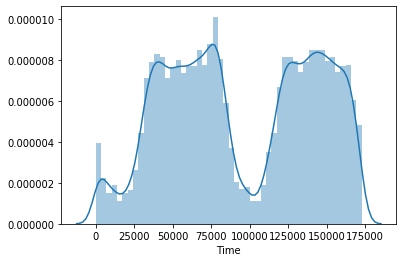

In [6]:
sns.distplot(X_train_raw['Time'])

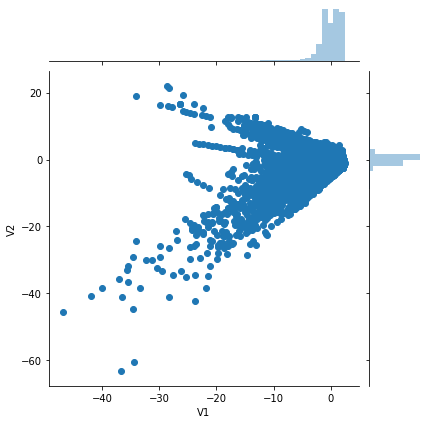

In [7]:
sns.jointplot(x="V1", y="V2", data=X_train_raw)

## Data Transformation and Standardization

In this section I perform a Yeo-Johnson power transformation and then apply a MinMaxScaler to force each PCA feature and Amount to be in the range [-1,1].  I treat Time differently, first I subtract 86,400 seconds (one day's worth) from all times greater than 86,400, thus createing a sawtooth "Time of Day" variable from the linear Time varaible.  Next I take the sine of the "Time of Day", changing the period of the sine curve to be over 86,400 instead of 2pi.  

In [8]:
#Extract the Time feature to be treated differently
Time_train = X_train_raw['Time']
Time_test = X_test_raw['Time']
X_train_raw = X_train_raw.drop('Time', axis=1)
X_test_raw = X_test_raw.drop('Time', axis=1)

#apply the Yeo-Johnson power transform
pt = PowerTransformer()
pt.fit(X_train_raw, 'yeo-johnson')
X_train = pt.transform(X_train_raw)
X_test = pt.transform(X_test_raw)

#apply the MinMaxScaler transform
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#recombine the Time feature with the transformed dataset
X_train = pd.DataFrame(X_train)
Time_train = pd.DataFrame(Time_train)
Time_train.index = X_train.index
X_train['Time'] = Time_train

X_test = pd.DataFrame(X_test)
Time_test = pd.DataFrame(Time_test)
Time_test.index = X_test.index
X_test['Time'] = Time_test

#rename columns lost during power transform
X_train.columns = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18",
                   "V19","V20","V21","V22","V23","V24","V25","V26","V27","V28",'Amount','Time']
X_test.columns = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18",
                   "V19","V20","V21","V22","V23","V24","V25","V26","V27","V28",'Amount','Time']

#subtract 86,400 seconds if greater than 86,400
X_train['Time'] = X_train['Time'].apply(lambda x: x-(24*3600) if x > 24*3600 else x)
X_test['Time'] = X_test['Time'].apply(lambda x: x-(24*3600) if x > 24*3600 else x)

#apply sin transformation
X_train["Time"] = X_train['Time'].apply(lambda x: math.sin((2*np.pi*x)/(24*3600)))
X_test["Time"] = X_test['Time'].apply(lambda x: math.sin((2*np.pi*x)/(24*3600)))

## Feature Visualization

This code creates a matplotlib histogram for each of the features transformed in the previous section.  It has been commented out because it takes a lot of space.  Most features are well-behaved (i.e. they look Gaussian), however V1 and Amount look somewhat non-normal.  They are called out here.   

In [9]:
#for var in X_train:
#    plt.hist(X_train[var], bins=100)
#    plt.title(var)
#    plt.show()

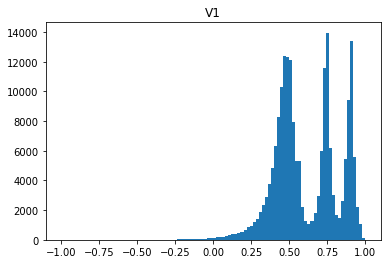

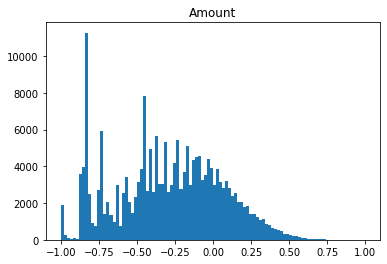

In [10]:
X_train_sub = X_train[['V1', 'Amount']]
for var in X_train_sub:
    plt.hist(X_train_sub[var], bins=100)
    plt.title(var)
    plt.show()

## K-Means n_clusters Selection

We calculate a Silhouette Coefficient for 10k and 20k subsample of the training data for n_clusters = [2,9].  We find that k=2 has the highest coefficient value.

In [11]:
#define the range of n_custers
r = range(2,10)

#Silhouette coefficient for 10k samples
sil = []
for k in r:
    kmeans = KMeans(n_clusters = k, random_state = 47)
    kmeans.fit(X_train)
    sil.append(silhouette_score(X_train, kmeans.labels_, sample_size=10000, random_state=47))

#Silhouette coefficient for 20k samples
sil2 = []
for k in r:
    kmeans = KMeans(n_clusters = k, random_state = 47)
    kmeans.fit(X_train)
    sil2.append(silhouette_score(X_train, kmeans.labels_, sample_size=20000, random_state=48))

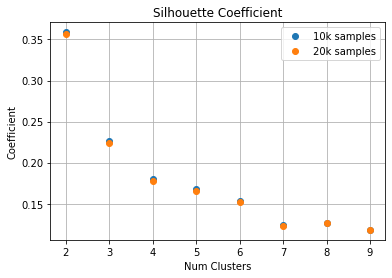

In [12]:
#Plot silhouette coefficient
plt.plot(r, sil, 'o', label = '10k samples')
plt.plot(r, sil2, 'o', label = '20k samples')
plt.grid(True)
plt.xticks(range(2,10))
plt.legend()
plt.title('Silhouette Coefficient')
plt.ylabel('Coefficient')
plt.xlabel('Num Clusters')
plt.show()

## Execute K-Means Clustering

In [13]:
kmeans = KMeans(n_clusters=2, random_state=47)
kmeans.fit(X_train)

X_train['Cluster'] = kmeans.labels_

## Cross Validation

In [14]:
ROC = pd.DataFrame([])
kf = KFold(n_splits=10)

#test n_comp = [1,4] for GMM
for n_comp in range(1,5):

    gm = GaussianMixture(n_components=n_comp)
    
    #Execute 10-fold cross-validation
    for train_index, test_index in kf.split(X_train):
        X_train_kf = X_train.iloc[train_index]
        X_test_kf = X_train.iloc[test_index]
        y_train_kf = y_train.iloc[train_index]
        y_test_kf = y_train.iloc[test_index]

        df = pd.DataFrame([])
        
        #Calculate probability that a sample belongs to each of the clusters.
        for cluster in range(0,2):
            gm.fit(X_train_kf[X_train_kf['Cluster'] == cluster].drop('Cluster', axis = 1))
            df[cluster] = gm.score_samples(X_test_kf.drop('Cluster', axis = 1))
        
        #Score samples produces a log prob, we take the exponent to calculate probability.
        outputs = np.exp(df.max(axis = 1))
        
        #Create array of threshold values, logspace
        N = 76
        thresh = np.logspace(-50,25, N)

        #Make predictions based on threshold value 
        TPR_list = []
        FPR_list = []
        for t in thresh:
            predictions = []
            for output in outputs:
                if output < t:
                    predictions.append(1)
                else:
                    predictions.append(0)
            
            #Create dataframe containing predictions and actual outcomes for KFold
            df_test_outcomes = pd.DataFrame({'predictions':predictions,'y_test':y_test_kf})
            
            #Calculate true positive rate and false positive rate for each fold
            TP = df_test_outcomes[(df_test_outcomes['predictions'] == 1) & (df_test_outcomes['y_test'] == 1)].shape[0]
            TN = df_test_outcomes[(df_test_outcomes['predictions'] == 0) & (df_test_outcomes['y_test'] == 0)].shape[0]
            FP = df_test_outcomes[(df_test_outcomes['predictions'] == 1) & (df_test_outcomes['y_test'] == 0)].shape[0]
            FN = df_test_outcomes[(df_test_outcomes['predictions'] == 0) & (df_test_outcomes['y_test'] == 1)].shape[0]

            TPR = TP/(TP+FN)
            spec = TN/(TN+FP)
            FPR = 1-spec

            TPR_list.append(TPR)
            FPR_list.append(FPR)

            TPR_str = 'TPR_' + str(n_comp)
            FPR_str = 'FPR_' + str(n_comp)

        if ROC.shape[0] >0:
            ROC_tmp = pd.DataFrame({TPR_str:TPR_list, FPR_str:FPR_list})
            ROC_tmp.index = thresh
            ROC = pd.concat([ROC, ROC_tmp], axis=1)
        else:
            ROC = pd.DataFrame({TPR_str:TPR_list, FPR_str:FPR_list})
            ROC.index = thresh

#Take the average of ROC calculations for folds with same number of components
ROC_kf = {}
for n in range(1,n_comp+1):
    ROC_kf['TPR_'+str(n)] = ROC['TPR_'+str(n)].mean(axis=1)
    ROC_kf['FPR_'+str(n)] = ROC['FPR_'+str(n)].mean(axis=1)

#Convert ROC_kf into dataframe
ROC_kf = pd.DataFrame(ROC_kf)

## Plot Validation ROC curves

(0, 1)

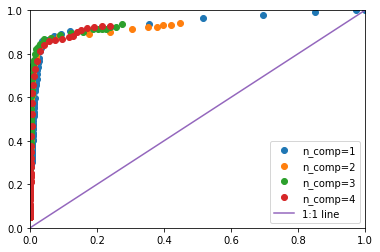

In [15]:
plt.plot(ROC_kf['FPR_1'], ROC_kf['TPR_1'], 'o', label='n_comp=1')
plt.plot(ROC_kf['FPR_2'], ROC_kf['TPR_2'], 'o', label='n_comp=2')
plt.plot(ROC_kf['FPR_3'], ROC_kf['TPR_3'], 'o', label='n_comp=3')
plt.plot(ROC_kf['FPR_4'], ROC_kf['TPR_4'], 'o', label='n_comp=4')
plt.plot([0,1],[0,1], label = '1:1 line')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)

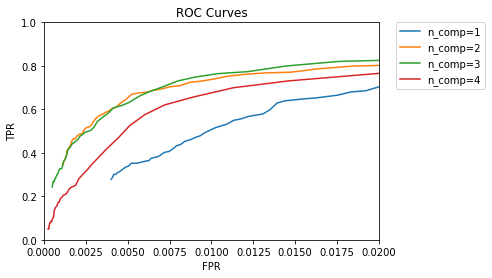

In [16]:
plt.plot(ROC_kf['FPR_1'], ROC_kf['TPR_1'], label='n_comp=1')
plt.plot(ROC_kf['FPR_2'], ROC_kf['TPR_2'], label='n_comp=2')
plt.plot(ROC_kf['FPR_3'], ROC_kf['TPR_3'], label='n_comp=3')
plt.plot(ROC_kf['FPR_4'], ROC_kf['TPR_4'], label='n_comp=4')
plt.xlim(0,0.02)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.show()

## Validation AUC

In [17]:
AUC = auc(np.append(np.insert(np.array(ROC_kf['FPR_3']),0,0,0),1), np.append(np.insert(np.array(ROC_kf['TPR_3']),0,0,0),1))
    
AUC

0.9443590254672574

## Test

In [18]:
#Take best performing n_comp from validation.
ROC = pd.DataFrame([])
n_comp = 3

gm = GaussianMixture(n_components=n_comp)
df = pd.DataFrame([])

#Calculate probability that a sample belongs to each of the clusters.
for cluster in range(0,2):
    gm.fit(X_train[X_train['Cluster'] == cluster].drop('Cluster', axis = 1))
    df[cluster] = gm.score_samples(X_test)
    
#Score samples produces a log prob, we take the exponent to calculate probability.
outputs = np.exp(df.max(axis = 1))

#Create array of threshold values, logspace
N = 76
thresh = np.logspace(-50,25, N)

#Make predictions based on threshold value
TPR_list = []
FPR_list = []
for t in thresh:
    predictions = []
    for output in outputs:
        if output < t:
            predictions.append(1)
        else:
            predictions.append(0)

    #Create dataframe containing predictions and actual outcomes for KFold
    df_test_outcomes = pd.DataFrame({'predictions':predictions,'y_test':y_test})
    
    #Calculate true positive rate and false positive rate for each fold
    TP = df_test_outcomes[(df_test_outcomes['predictions'] == 1) & (df_test_outcomes['y_test'] == 1)].shape[0]
    TN = df_test_outcomes[(df_test_outcomes['predictions'] == 0) & (df_test_outcomes['y_test'] == 0)].shape[0]
    FP = df_test_outcomes[(df_test_outcomes['predictions'] == 1) & (df_test_outcomes['y_test'] == 0)].shape[0]
    FN = df_test_outcomes[(df_test_outcomes['predictions'] == 0) & (df_test_outcomes['y_test'] == 1)].shape[0]

    TPR = TP/(TP+FN)
    spec = TN/(TN+FP)
    FPR = 1-spec

    TPR_list.append(TPR)
    FPR_list.append(FPR)

    TPR_str = 'TPR_' + str(n_comp)
    FPR_str = 'FPR_' + str(n_comp)

#Compose ROC dataframe
ROC = pd.DataFrame({TPR_str:TPR_list, FPR_str:FPR_list})       
ROC.index = thresh

## Plot Test ROC cruve

(0, 1)

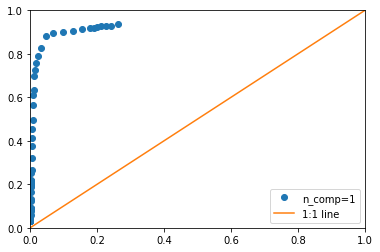

In [19]:
plt.plot(ROC['FPR_3'], ROC['TPR_3'], 'o', label='n_comp=1')
plt.plot([0,1],[0,1], label = '1:1 line')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)

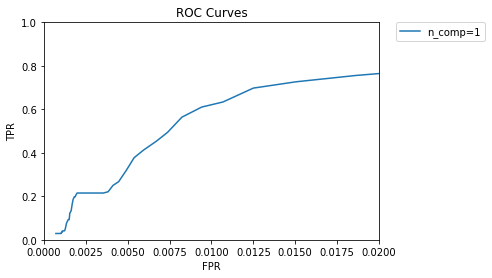

In [20]:
plt.plot(ROC['FPR_3'], ROC['TPR_3'], label='n_comp=1')
plt.xlim(0,0.02)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.show()

## Test AUC

In [21]:
AUC = auc(np.append(np.insert(np.array(ROC['FPR_3']),0,0,0),1), np.append(np.insert(np.array(ROC['TPR_3']),0,0,0),1))
    
AUC       

0.9435352895406246